In [102]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal as signal
import os
import sys
import glob
from typing import List

# Get the parent directory
parent_dir = os.path.dirname(os.path.dirname(os.path.realpath(os.path.curdir)))
print(parent_dir)
# Add the parent directory to sys.path
sys.path.append(parent_dir)

from tools.SimulatorData.SimulatorData import SimulatorData

# Load the data
# Load the data
data_dir = [
    os.path.join(parent_dir, "data\patient12\S001"),
    os.path.join(parent_dir, "data\patient12\S002"),
]

sim_data_files = []
for i in range(len(data_dir)):
    sim_data_files.append(glob.glob(os.path.join(data_dir[i], "*SimulatorData.csv"))[0])

from tools.SimulatorData.SimulatorData import SimulatorData

# Load the data
sim_data: List[SimulatorData] = []
for i in range(len(sim_data_files)):
    sim_data.append(SimulatorData(sim_data_files[i]))

C:\Users\victo\Documents\Code\signal_processing


### Erratic driving score


In [103]:
def erratic_driving_score(
    time,
    road_positions,
    car_speed,
    window_size,
    overlap,
    fs,
    upper_boundary,
    lower_boundary,
    std_dev_threshold,
    centered=0,
):
    road_positions = np.array(road_positions)
    car_speed = np.array(car_speed)
    time = np.array(time)
    step = int(window_size * overlap)

    # Create windows
    road_positions_segment = [
        road_positions[i : i + window_size] for i in range(0, len(road_positions), step)
    ]
    car_speed_segment = [
        car_speed[i : i + window_size] for i in range(0, len(car_speed), step)
    ]
    time_segment = [time[i : i + window_size] for i in range(0, len(time), step)]

    # Preallocate the EDS
    eds_array = np.zeros(len(road_positions_segment))
    time_array = np.zeros(len(road_positions_segment))
    lpv_array = np.zeros(len(road_positions_segment))
    fbc_array = np.zeros(len(road_positions_segment))
    edc_array = np.zeros(len(road_positions_segment))
    sv_array = np.zeros(len(road_positions_segment))
    szc_array = np.zeros(len(road_positions_segment))
    per_elp_array = np.zeros(len(road_positions_segment))

    for seg_idx in range(len(road_positions_segment)):
        # Lateral Position Variability (LPV) over a moving window
        lpv = np.std(road_positions_segment[seg_idx]) 
        
        # Frequency of Boundary Crossings (FBC) over the same moving window
        fbc = np.sum(
            np.abs(np.diff((road_positions_segment[seg_idx] > upper_boundary) | (road_positions_segment[seg_idx] < lower_boundary)))
        ).astype(int) / len(road_positions_segment[seg_idx])
        
        # Percent of time spent in extreme lateral positions
        per_elp = np.sum(
            (road_positions_segment[seg_idx] > upper_boundary) | (road_positions_segment[seg_idx] < lower_boundary)
        ).astype(int) / len(road_positions_segment[seg_idx])
        
        # Extreme Deviation Counts (EDC) with respect to moving standard deviation
        edc = np.sum(
            (road_positions_segment[seg_idx] > np.mean(road_positions_segment[seg_idx]) + std_dev_threshold * lpv)
            | (road_positions_segment[seg_idx] < np.mean(road_positions_segment[seg_idx]) - std_dev_threshold * lpv)
        ).astype(int) / len(road_positions_segment[seg_idx])
        
        # Speed variability (SV) over a moving window
        sv = car_speed_segment[seg_idx].std() 
        
        # Compute the number of zero crossings of the speed signal
        diff_car_speed = np.diff(car_speed_segment[seg_idx])
        szc = np.sum(diff_car_speed[:-1] * diff_car_speed[1:] < 0).astype(int) / len(car_speed_segment[seg_idx])

        # Weight factors for EDS (adjustable)
        w_lpv, w_fbc, w_edc, w_sv, w_szc, w_per_elp = 1, 0.75, 0.5, 0.5, 0.0, 0.5  # Modify these weights as needed
        
        # Compute EDS
        eds = (w_lpv * lpv + w_fbc * fbc + w_edc * edc + w_sv * sv + w_szc * szc + w_per_elp * per_elp) 
        eds_array[seg_idx] = eds
        
        lpv_array[seg_idx] = lpv
        fbc_array[seg_idx] = fbc
        edc_array[seg_idx] = edc
        sv_array[seg_idx] = sv
        szc_array[seg_idx] = szc
        per_elp_array[seg_idx] = per_elp
        
        if centered == 1:
            time_array[seg_idx] = np.mean(
                time_segment[seg_idx]
            )
        else:
            time_array[seg_idx] = time_segment[
                seg_idx
            ][-1]
    
    data = {
        "Time": time_array,
        "EDS": eds_array,
        "LPV": lpv_array,
        "FBC": fbc_array,
        "EDC": edc_array,
        "SV": sv_array,
        "SZC": szc_array,
        "PER_ELP": per_elp_array
    }

    return time_array, eds_array, data

### Define parameters


In [104]:
# Parameters for calculations
window_size = sim_data[0].new_fs * 120  # Window size for LPV calculation
upper_boundary_threshold = 2.511  # Threshold for FBC and EDC calculations
lower_boundary_threshold = 0.837
std_dev_threshold = 3  # Threshold for EDC calculation based on standard deviation

### Compute Erratic score


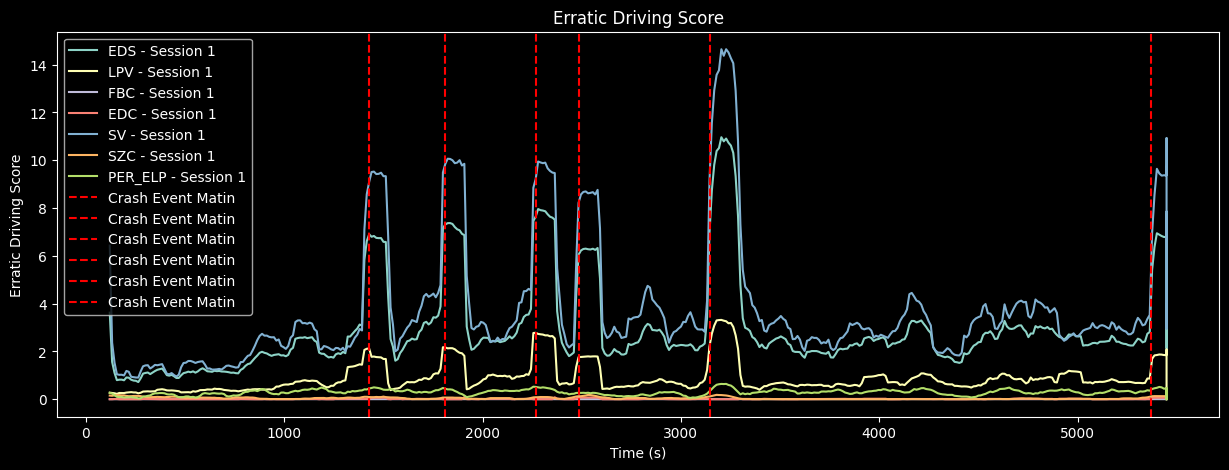

In [105]:
# Compute the erratic driving score
eds = []
time = []
data_arr = []
for i in range(len(sim_data)):
    x, y, data = erratic_driving_score(sim_data[i].time ,sim_data[i].road_position, sim_data[i].speed, window_size, 0.1, sim_data[0].new_fs, upper_boundary_threshold, lower_boundary_threshold, std_dev_threshold)
    data_arr.append(data)
    eds.append(y)
    time.append(x)

# Plot the results
plt.figure(figsize=(15, 5))
plt.plot(time[0], eds[0], label='EDS - Session 1')
# plt.plot(time[1], eds[1], label='EDS - Session 2')
plt.plot(time[0], data_arr[0]['LPV'], label='LPV - Session 1')
plt.plot(time[0], data_arr[0]['FBC'], label='FBC - Session 1')
plt.plot(time[0], data_arr[0]['EDC'], label='EDC - Session 1')
plt.plot(time[0], data_arr[0]['SV'], label='SV - Session 1')
plt.plot(time[0], data_arr[0]['SZC']*100, label='SZC - Session 1')
plt.plot(time[0], data_arr[0]['PER_ELP'], label='PER_ELP - Session 1')
# plt.plot(time[1], data_arr[1]['LPV'], label='LPV - Session 2')
# plt.plot(time[1], data_arr[1]['FBC'], label='FBC - Session 2')
# plt.plot(time[1], data_arr[1]['EDC'], label='EDC - Session 2')
# plt.plot(time[1], data_arr[1]['SV'], label='SV - Session 2')
# plt.plot(time[1], data_arr[1]['SZC'], label='SZC - Session 2')
# plt.plot(time[1], data_arr[1]['PER_ELP'], label='PER_ELP - Session 2')

for i in range(len(sim_data[0].crash_time)):
    plt.axvline(x=sim_data[0].crash_time[i]*60, color='r', linestyle='--', label='Crash Event Matin')
for i in range(len(sim_data[1].crash_time)):
    plt.axvline(x=sim_data[1].crash_time[i]*60, color='r', linestyle='--', label='Crash Event Soir')
# plt.ylim((0, 15))
plt.xlabel('Time (s)')
plt.ylabel('Erratic Driving Score')
plt.title('Erratic Driving Score')
plt.legend()
plt.show()

In [106]:
# def old_erratic_driving_score(
#     time,
#     road_positions,
#     window_size,
#     overlap,
#     fs,
#     upper_boundary,
#     lower_boundary,
#     std_dev_threshold,
#     centered=0,
# ):
#     road_positions = np.array(road_positions)
#     time = np.array(time)
#     step = int(window_size * overlap)
    
#     # Set the EDS coefficients
#     w_lpv, w_fbc, w_edc = 1, 0.75, 0.5  # Modify these weights as needed

#     # Create windows

#     road_positions_segment = [
#         road_positions[i : i + window_size] for i in range(0, len(road_positions), step)
#     ]
#     time_segment = [time[i : i + window_size] for i in range(0, len(time), step)]

#     # Preallocate the EDS
#     eds_array = np.zeros(len(road_positions_segment))
#     time_array = np.zeros(len(road_positions_segment))

#     for seg_idx, segment in enumerate(road_positions_segment):
#         lpv = np.std(segment)
#         fbc = np.sum(
#             np.abs(np.diff((segment > upper_boundary) | (segment < lower_boundary)))
#         ).astype(int)
#         edc = np.sum(
#             (segment > np.mean(segment) + std_dev_threshold * lpv)
#             | (segment < np.mean(segment) - std_dev_threshold * lpv)
#         ).astype(int)

#         # Compute EDS
#         eds = w_lpv * lpv + w_fbc * fbc + w_edc * edc
#         eds_array[seg_idx] = eds / (window_size*fs)

#         if centered == 1:
#             time_array[seg_idx] = np.mean(
#                 time_segment[seg_idx]
#             )
#         else:
#             time_array[seg_idx] = time_segment[
#                 seg_idx
#             ][-1]

#     return time_array, eds_array

In [107]:

# def erratic_driving_score(
#     road_positions,
#     car_speed,
#     window_size,
#     fs,
#     upper_road_boundary,
#     lower_road_boundary,
#     std_dev_threshold,
# ):
#     """ 
#         ideas : À chaque sorti de route on regarde jusqu'a quel distance il séloigne et on assigne un score plus ou moins fort en fonction de a quel point il sort loin
#     """
#     # Convert road positions to a pandas series
#     road_positions = pd.Series(road_positions)
#     car_speed = pd.Series(car_speed)
    
#     # Calculate Erratic Driving Metrics
#     # Lateral Position Variability (LPV) over a moving window
#     # Lateral Position Variability (LPV) over a moving window
#     lpv = road_positions.rolling(window=window_size, center=True).std()

#     # Frequency of Boundary Crossings (FBC) over the same moving window
#     fbc = (
#         (
#             (road_positions > upper_road_boundary)
#             | (road_positions < lower_road_boundary)
#         )
#         .astype(int)
#         .diff()
#         .abs()
#     )
#     fbc_windowed = fbc.rolling(window=window_size, center=True).sum() / (
#         window_size * fs
#     )

#     # Extreme Deviation Counts (EDC) with respect to moving standard deviation
#     edc = (
#         (
#             road_positions
#             > road_positions.rolling(window=window_size, center=True).mean()
#             + std_dev_threshold * lpv
#         )
#         | (
#             road_positions
#             < road_positions.rolling(window=window_size, center=True).mean()
#             - std_dev_threshold * lpv
#         )
#     ).astype(int)
#     edc_windowed = edc.rolling(window=window_size, center=True).sum() / (
#         window_size * fs
#     )
    
#     # Speed variability (SV) over a moving window
#     sv = car_speed.rolling(window=window_size, center=True).std()
    
#     # Compute the number of zero crossings of the speed signal
#     diff_car_speed = car_speed.diff()
#     zero_crossings = diff_car_speed[-1:] * diff_car_speed[:-1] < 0
#     szc = zero_crossings.rolling(window=window_size, center=True).sum()

#     # Weight factors for EDS (adjustable)
#     w_lpv, w_fbc, w_edc, w_sv, w_szc = 1, 0.75, 0.5, 0.5, 0.5  # Modify these weights as needed

#     # Calculate EDS (assuming FBC and EDC apply uniformly over time; adjust as necessary for different assumptions)
#     eds = (w_lpv * lpv )
#     eds_smoothing_window = 25 * 120  # Window size for smoothing EDS
#     eds_smoothed = eds.rolling(window=eds_smoothing_window, center=True).mean()

#     return eds_smoothed